В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [3]:
DATA_DIR = '/kaggle/input/'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
def get_dataloader(image_size, batch_size, stats):
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [5]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_dl = get_dataloader(image_size, batch_size, stats)

In [8]:
print(f'Кол-во кратинок в датасете: {len(train_dl) * 64}')

Кол-во кратинок в датасете: 3200


In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

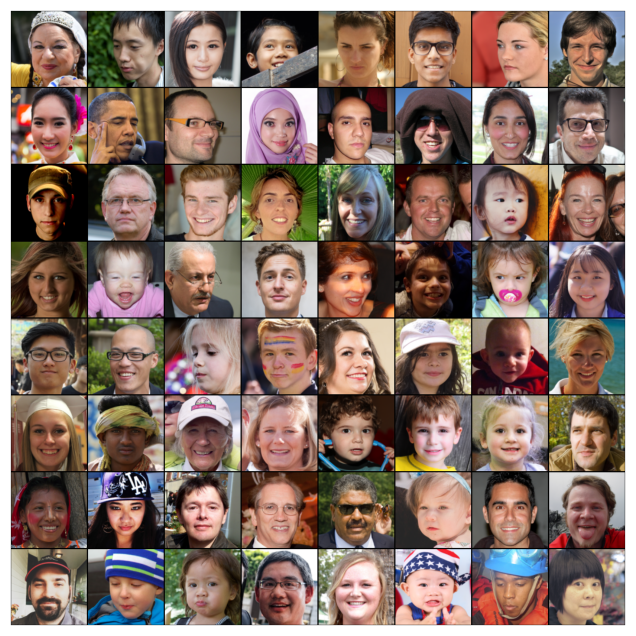

In [10]:
show_batch(train_dl)

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла) *(Я строю модель WGAN-GP)*

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=True),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LayerNorm([128, 32, 32]),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LayerNorm([256, 16, 16]),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LayerNorm([512, 8, 8]),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten()
)

In [12]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, 0, 0.01)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.normal_(m.weight, 1.0, 0.01)
        nn.init.constant_(m.bias, 0)

discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): LayerNorm((256, 16, 16), eps=1e-05, elementwise_affine=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): LayerNorm((512, 8, 8), eps=1e-05, elementwise_affine=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Flatten(start_dim=1, end_dim=-1)
)

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size=256

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [17]:
generator = to_device(generator, device)

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
# штраф за градиент (gradient penalty), который заменяет обрезание весов (weight clipping) из оригинального WGAN
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    d_interpolates = D(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [21]:
device='cuda' if torch.cuda.is_available else 'cpu'

In [22]:
def fit(model, train_dl, latent_size, device, epochs=50, lr_D=1e-4, lr_G=1e-4, n_critic=10, lambda_gp=1, fixed_latent=None):
    model["discriminator"] = model["discriminator"].to(device)
    model["generator"] = model["generator"].to(device)
    
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Optimizers
    optimizer_D = torch.optim.Adam(model["discriminator"].parameters(), lr=lr_D, betas=(0.0, 0.9))
    optimizer_G = torch.optim.Adam(model["generator"].parameters(), lr=lr_G, betas=(0.0, 0.9))

    # Loss tracking
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        loss_d_epoch = []
        loss_g_epoch = []
        real_score_epoch = []
        fake_score_epoch = []

        for batch_idx, (real_images, _) in enumerate(tqdm(train_dl)):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # =================================
            #  Train Discriminator (Critic)
            # =================================
            optimizer_D.zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Real and fake predictions
            real_preds = model["discriminator"](real_images)
            fake_preds = model["discriminator"](fake_images.detach())  # detach здесь важен

            # Gradient penalty
            gp = compute_gradient_penalty(model["discriminator"], real_images, fake_images, device)

            # Discriminator loss
            loss_d = -torch.mean(real_preds) + torch.mean(fake_preds) + lambda_gp * gp
            loss_d.backward()
            optimizer_D.step()

            # Record scores
            real_score_epoch.append(torch.mean(real_preds).item())
            fake_score_epoch.append(torch.mean(fake_preds).item())
            loss_d_epoch.append(loss_d.item())

            # =================================
            #  Train Generator
            # =================================
            if batch_idx % n_critic == 0:
                optimizer_G.zero_grad()

                # Generate new fake images (не используем старые!)
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = model["generator"](latent)

                # Try to fool the discriminator
                fake_preds = model["discriminator"](fake_images)
                loss_g = -torch.mean(fake_preds)
                loss_g.backward()
                optimizer_G.step()

                loss_g_epoch.append(loss_g.item())

        # Сохраняем метрики эпохи
        losses_d.append(np.mean(loss_d_epoch))
        losses_g.append(np.mean(loss_g_epoch) if loss_g_epoch else 0)
        real_scores.append(np.mean(real_score_epoch))
        fake_scores.append(np.mean(fake_score_epoch))

        if epoch == epochs - 1:
            save_samples(epoch + 1, fixed_latent, show=False)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"D loss: {losses_d[-1]:.4f} | "
              f"G loss: {losses_g[-1]:.4f} | "
              f"D(x): {real_scores[-1]:.4f} | "
              f"D(G(z)): {fake_scores[-1]:.4f}")

    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/60] | D loss: 13.7790 | G loss: -4.0625 | D(x): 1.3333 | D(G(z)): 4.1990


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/60] | D loss: 0.8258 | G loss: -1.7440 | D(x): 1.2200 | D(G(z)): 1.8426


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/60] | D loss: -0.6777 | G loss: -0.6279 | D(x): 1.5151 | D(G(z)): 0.6778


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/60] | D loss: 0.2761 | G loss: -0.9315 | D(x): 0.9597 | D(G(z)): 1.1031


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/60] | D loss: 0.1473 | G loss: 0.0630 | D(x): -0.0970 | D(G(z)): 0.0117


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/60] | D loss: 0.1331 | G loss: 0.4969 | D(x): -0.5304 | D(G(z)): -0.4220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/60] | D loss: 0.1226 | G loss: 0.4377 | D(x): -0.4674 | D(G(z)): -0.3705


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/60] | D loss: 0.0797 | G loss: 0.1401 | D(x): -0.1591 | D(G(z)): -0.1048


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/60] | D loss: 0.0859 | G loss: 0.1748 | D(x): -0.1765 | D(G(z)): -0.1170


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/60] | D loss: 0.0871 | G loss: 0.1358 | D(x): -0.1588 | D(G(z)): -0.0974


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/60] | D loss: 0.0840 | G loss: 0.0817 | D(x): -0.0977 | D(G(z)): -0.0397


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/60] | D loss: 0.0760 | G loss: 0.1057 | D(x): -0.1195 | D(G(z)): -0.0681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/60] | D loss: 0.0768 | G loss: 0.0736 | D(x): -0.1006 | D(G(z)): -0.0457


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/60] | D loss: 0.0782 | G loss: 0.0421 | D(x): -0.0720 | D(G(z)): -0.0163


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/60] | D loss: 0.0774 | G loss: 0.0647 | D(x): -0.0934 | D(G(z)): -0.0407


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/60] | D loss: 0.0754 | G loss: 0.0750 | D(x): -0.0968 | D(G(z)): -0.0433


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/60] | D loss: 0.0787 | G loss: 0.1029 | D(x): -0.1290 | D(G(z)): -0.0733


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/60] | D loss: 0.0748 | G loss: 0.1240 | D(x): -0.1536 | D(G(z)): -0.1014


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/60] | D loss: 0.0727 | G loss: 0.1380 | D(x): -0.1628 | D(G(z)): -0.1117


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/60] | D loss: 0.0731 | G loss: 0.1130 | D(x): -0.1475 | D(G(z)): -0.0946


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/60] | D loss: 0.0724 | G loss: 0.0813 | D(x): -0.1158 | D(G(z)): -0.0632


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/60] | D loss: 0.0706 | G loss: 0.0484 | D(x): -0.0722 | D(G(z)): -0.0207


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/60] | D loss: 0.0686 | G loss: 0.0575 | D(x): -0.0903 | D(G(z)): -0.0391


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/60] | D loss: 0.0647 | G loss: 0.0364 | D(x): -0.0603 | D(G(z)): -0.0127


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/60] | D loss: 0.0656 | G loss: 0.0535 | D(x): -0.0807 | D(G(z)): -0.0316


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/60] | D loss: 0.0651 | G loss: 0.0809 | D(x): -0.1077 | D(G(z)): -0.0583


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/60] | D loss: 0.0641 | G loss: 0.1425 | D(x): -0.1733 | D(G(z)): -0.1250


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/60] | D loss: 0.0637 | G loss: 0.1573 | D(x): -0.1914 | D(G(z)): -0.1423


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/60] | D loss: 0.0620 | G loss: 0.1683 | D(x): -0.1957 | D(G(z)): -0.1478


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/60] | D loss: 0.0593 | G loss: 0.1918 | D(x): -0.2169 | D(G(z)): -0.1699


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/60] | D loss: 0.0602 | G loss: 0.1685 | D(x): -0.2011 | D(G(z)): -0.1532


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/60] | D loss: 0.0588 | G loss: 0.1704 | D(x): -0.1978 | D(G(z)): -0.1510


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/60] | D loss: 0.0578 | G loss: 0.1873 | D(x): -0.2180 | D(G(z)): -0.1715


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/60] | D loss: 0.0558 | G loss: 0.2091 | D(x): -0.2406 | D(G(z)): -0.1962


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/60] | D loss: 0.0555 | G loss: 0.2201 | D(x): -0.2471 | D(G(z)): -0.2021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/60] | D loss: 0.0542 | G loss: 0.2007 | D(x): -0.2284 | D(G(z)): -0.1843


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/60] | D loss: 0.0510 | G loss: 0.1506 | D(x): -0.1849 | D(G(z)): -0.1430


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/60] | D loss: 0.0550 | G loss: 0.1753 | D(x): -0.1947 | D(G(z)): -0.1487


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/60] | D loss: 0.0539 | G loss: 0.1937 | D(x): -0.2216 | D(G(z)): -0.1763


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/60] | D loss: 0.0542 | G loss: 0.1984 | D(x): -0.2283 | D(G(z)): -0.1829


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/60] | D loss: 0.0527 | G loss: 0.1675 | D(x): -0.2030 | D(G(z)): -0.1591


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/60] | D loss: 0.0537 | G loss: 0.1669 | D(x): -0.1891 | D(G(z)): -0.1439


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/60] | D loss: 0.0534 | G loss: 0.1072 | D(x): -0.1421 | D(G(z)): -0.0972


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/60] | D loss: 0.0528 | G loss: 0.0911 | D(x): -0.1206 | D(G(z)): -0.0760


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/60] | D loss: 0.0484 | G loss: 0.1014 | D(x): -0.1267 | D(G(z)): -0.0860


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/60] | D loss: 0.0527 | G loss: 0.1034 | D(x): -0.1330 | D(G(z)): -0.0881


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/60] | D loss: 0.0516 | G loss: 0.0810 | D(x): -0.1063 | D(G(z)): -0.0623


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/60] | D loss: 0.0479 | G loss: 0.0955 | D(x): -0.1223 | D(G(z)): -0.0814


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/60] | D loss: 0.0474 | G loss: 0.0907 | D(x): -0.1206 | D(G(z)): -0.0805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/60] | D loss: 0.0484 | G loss: 0.0787 | D(x): -0.1064 | D(G(z)): -0.0652


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/60] | D loss: 0.0476 | G loss: 0.0956 | D(x): -0.1174 | D(G(z)): -0.0767


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/60] | D loss: 0.0490 | G loss: 0.0934 | D(x): -0.1226 | D(G(z)): -0.0810


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/60] | D loss: 0.0478 | G loss: 0.0713 | D(x): -0.1028 | D(G(z)): -0.0624


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/60] | D loss: 0.0489 | G loss: 0.0908 | D(x): -0.1130 | D(G(z)): -0.0712


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/60] | D loss: 0.0479 | G loss: 0.0906 | D(x): -0.1155 | D(G(z)): -0.0747


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/60] | D loss: 0.0472 | G loss: 0.1169 | D(x): -0.1480 | D(G(z)): -0.1074


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/60] | D loss: 0.0470 | G loss: 0.1210 | D(x): -0.1418 | D(G(z)): -0.1013


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/60] | D loss: 0.0473 | G loss: 0.1107 | D(x): -0.1404 | D(G(z)): -0.0997


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/60] | D loss: 0.0476 | G loss: 0.1022 | D(x): -0.1310 | D(G(z)): -0.0901


  0%|          | 0/50 [00:00<?, ?it/s]

Saving generated-images-0060.png
Epoch [60/60] | D loss: 0.0445 | G loss: 0.0970 | D(x): -0.1225 | D(G(z)): -0.0844


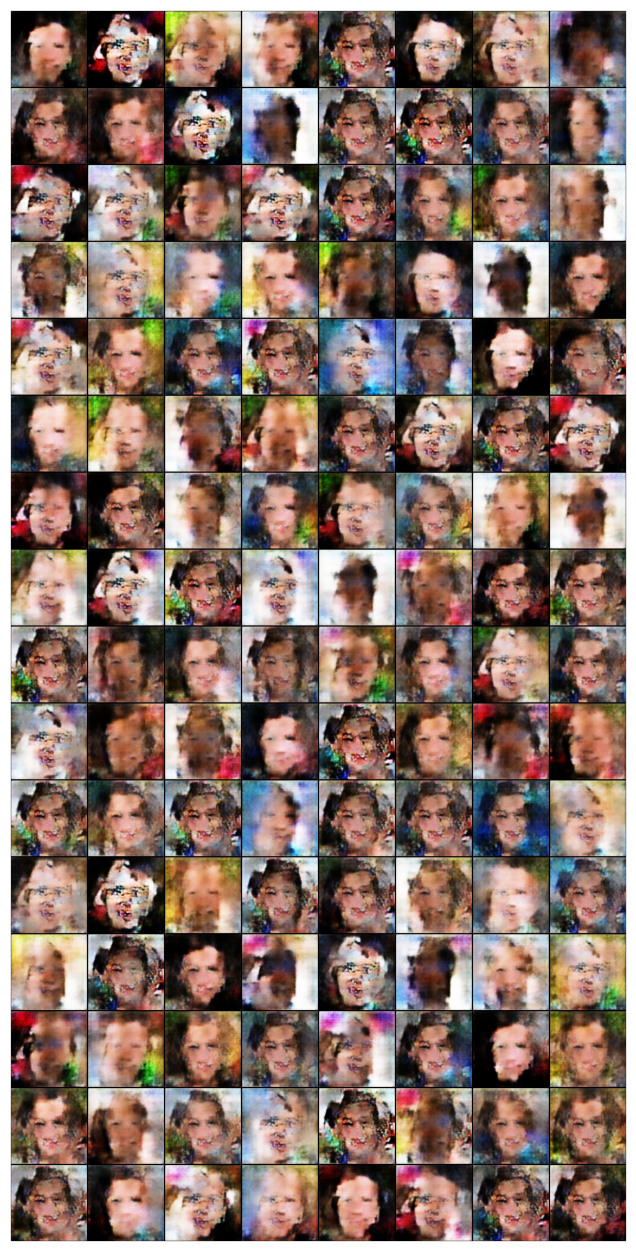

In [23]:
latent_size = 256
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
model = {
    "discriminator": discriminator,
    "generator": generator
}

history = fit(model, train_dl, latent_size, device, epochs=60, n_critic=1, lr_D=1e-5, lr_G=2e-4, fixed_latent=fixed_latent)
losses_g, losses_d, real_scores, fake_scores = history
generated_img = cv2.imread(f'./generated/generated-images-0060.png')
generated_img = generated_img[:, :, [2, 1, 0]]
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

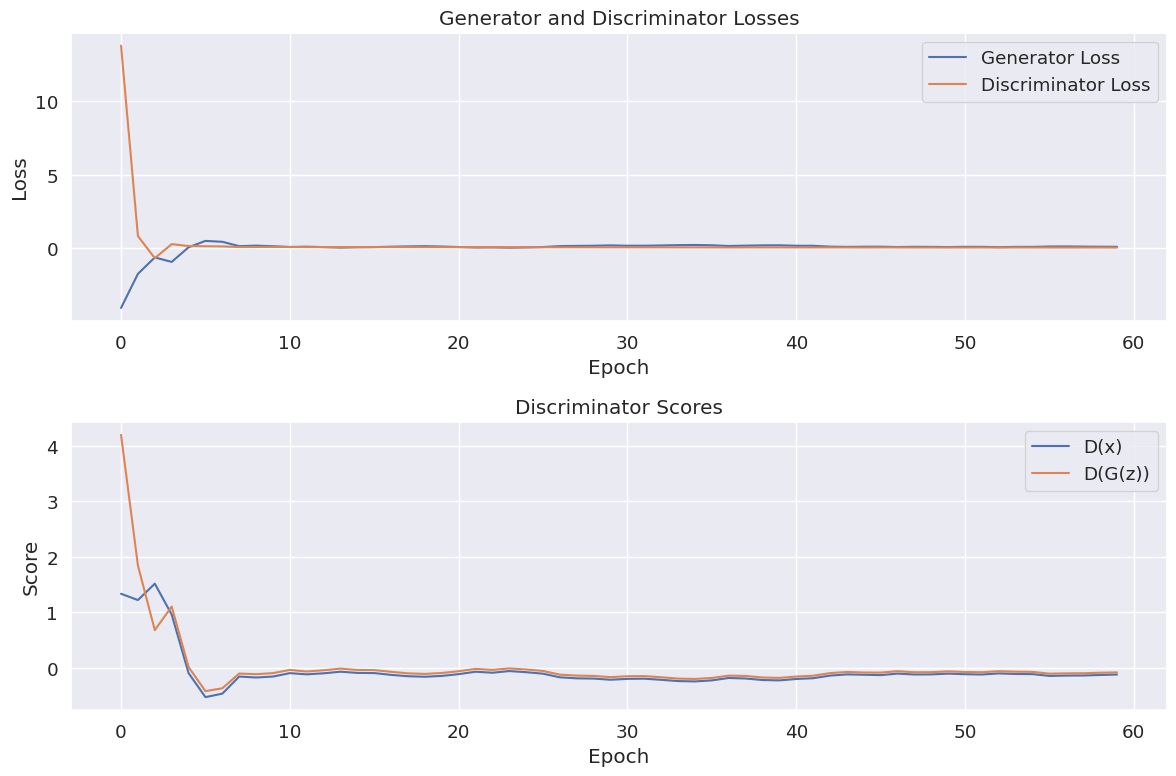

In [24]:
def plot_losses(losses_g, losses_d, real_scores, fake_scores):
    plt.figure(figsize=(12, 8))

    # График лоссов
    plt.subplot(2, 1, 1)
    plt.plot(losses_g, label='Generator Loss')
    plt.plot(losses_d, label='Discriminator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # График скоров
    plt.subplot(2, 1, 2)
    plt.plot(real_scores, label='D(x)')
    plt.plot(fake_scores, label='D(G(z))')
    plt.title('Discriminator Scores')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('wgan_gp_losses.png')
    plt.show()

plot_losses(losses_g, losses_d, real_scores, fake_scores)

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [25]:
n_images = 8

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [26]:
def show_images(generated):
    generated = denorm(generated)
    
    grid = make_grid(generated.cpu().detach(), nrow=4)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

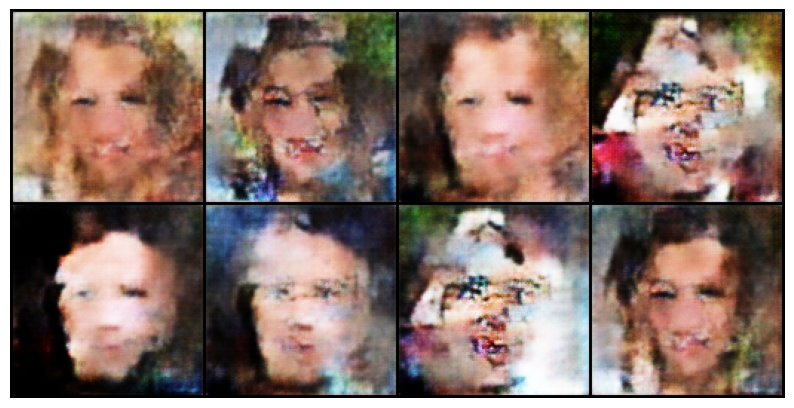

In [33]:
show_images(fake_images)

> Как вам качество получившихся изображений? Страх... Имеет смысл поэксперементировать с гиперпараметрами и увеличить кол-во эпох для лучшего результата

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:
def generate_fake_images(n_samples):
    latent = torch.randn(n_samples, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    return fake_images

In [39]:
import os
import torch
import numpy as np
from torch.cuda import empty_cache
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import gc

# Отключаем многопоточность для OpenBLAS и scikit-learn
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

def prepare_data(train_dl, generate_fake_images, max_samples=1000):
    """Подготавливает данные с ограничением максимального количества"""
    real_images = []
    total_samples = 0
    
    for batch in train_dl:
        if total_samples >= max_samples:
            break
        batch_size = batch[0].size(0)
        half_batch = batch[0][:batch_size//2]
        real_images.append(half_batch)
        total_samples += half_batch.size(0)
        del batch
        gc.collect()
    
    real_images = torch.cat(real_images, dim=0)[:max_samples]
    total_samples = real_images.size(0)
    empty_cache()

    fake_images = []
    batch_size = 32
    n_batches = (total_samples + batch_size - 1) // batch_size
    
    for i in range(n_batches):
        current_size = min(batch_size, total_samples - i*batch_size)
        with torch.no_grad():
            fake_batch = generate_fake_images(current_size)
            fake_images.append(fake_batch.cpu())
        empty_cache()
        gc.collect()
    
    fake_images = torch.cat(fake_images, dim=0)[:total_samples]
    
    X = torch.cat([real_images.cpu(), fake_images], dim=0)
    X = X.view(X.size(0), -1).cpu().numpy()
    y = np.concatenate([np.ones(total_samples), np.zeros(total_samples)])
    
    del real_images, fake_images
    gc.collect()
    
    return X, y

def evaluate_with_1nn(train_dl, generate_fake_images, n_splits=5, max_samples=1000):
    """Упрощенная оценка с ограничением выборки"""
    X, y = prepare_data(train_dl, generate_fake_images, max_samples)
    
    if len(X) > 10000:
        indices = np.random.choice(len(X), 10000, replace=False)
        X = X[indices]
        y = y[indices]
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute', n_jobs=1)
    
    accuracies = []
    for train_idx, test_idx in kf.split(X):
        try:
            clf.fit(X[train_idx], y[train_idx])
            acc = clf.score(X[test_idx], y[test_idx])
            accuracies.append(acc)
        except Exception as e:
            print(f"Ошибка в фолде: {str(e)}")
            continue
    
    if not accuracies:
        return 0.0
    
    mean_acc = np.mean(accuracies)
    print(f"1NN точность ({n_splits}-fold, {len(X)} samples): {mean_acc:.4f}")
    return mean_acc

In [40]:
evaluate_with_1nn(train_dl, generate_fake_images) 

1NN точность (5-fold, 2000 samples): 0.8880


0.8880000000000001

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Результат неплохой - модель способна отличать сгенерированные изображения от реальных, детектор обучился хорошо. Тем не менее, если перед нами задача генерации максимально неотличимых от реальных изображений, то мы бы хотели получить accuracy примерно 50% - тогда генератор будет "идеальный", модель не будет отличать фейковые и реальные изображения. 

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [41]:
def visualize_distributions(X, y):
    """Визуализирует распределения реальных и сгенерированных изображений с помощью t-SNE"""
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)
    
    real_points = X_tsne[y == 1]
    fake_points = X_tsne[y == 0]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(real_points[:, 0], real_points[:, 1], c='blue', label='Реальные изображения', alpha=0.5)
    plt.scatter(fake_points[:, 0], fake_points[:, 1], c='red', label='Сгенерированные изображения', alpha=0.5)
    
    plt.title('t-SNE визуализация распределений изображений')
    plt.xlabel('Первая компонента t-SNE')
    plt.ylabel('Вторая компонента t-SNE')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('tsne_visualization.png')
    plt.show()

In [44]:
from sklearn.manifold import TSNE

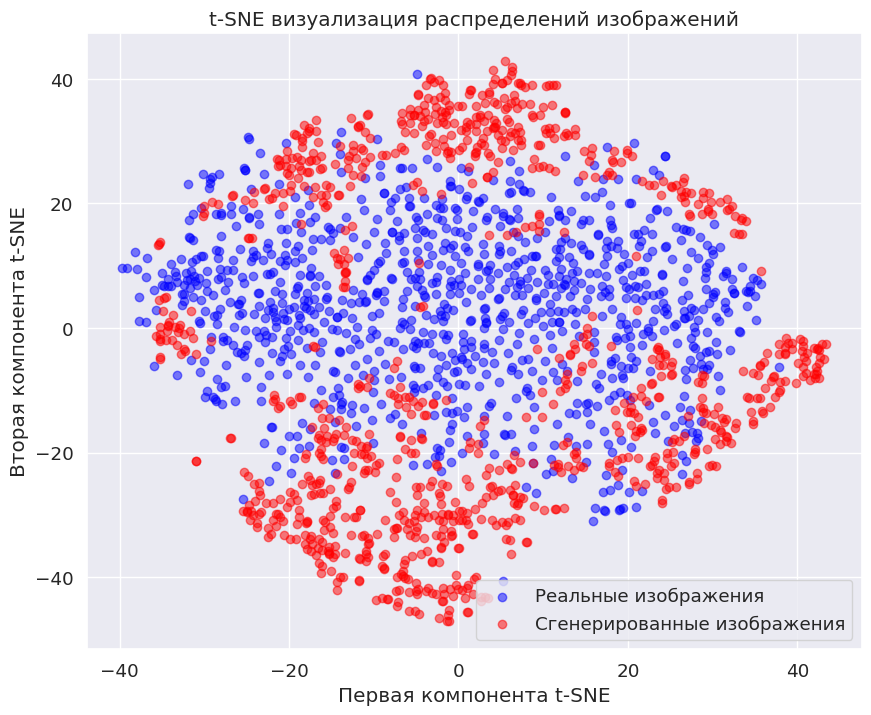

In [45]:
X, y = prepare_data(train_dl, generate_fake_images)

visualize_distributions(X, y)

Прокомментируйте получившийся результат: 

Видим, что реальные изображения принимают значения от -40 до 40 по первой компоненте и от -20 до 20 по второй. Фейковые изображения распределены от -40 до 40 по первой компоненте и имеют видимый разрыв по второй компоненте - значения сосредоточены между 20 и 40 и между -20 и -40. 

Визуализация указывает на недостаточно хорошую работу генератора из-за несовпадения распределений. Тем не менее, устранив разрыв по второй компоненте мы смогли бы говорить о высокой схожести реальных и фейковых изображений.